<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/denoising-autoencoder/Denoising_Autoencoder_Solution.ipynb

https://github.com/Andrew-Wyn/ISPR_HWS/blob/master/MidTerm3_1/ISPR_HW3.ipynb

In [1]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [2]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

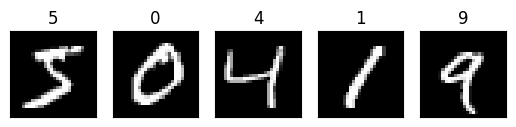

In [3]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device available: {device}")

The device available: cpu


# Preparing the dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train))
print("Min:", torch.min(X_train))

Max: tensor(1.)
Min: tensor(0.)


Ho scelto di implementare un deoising autoncoder quindi aggiungo noise al dataset

In [6]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

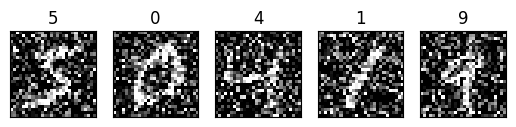

In [7]:
noise_std = 0.5
X_train_noisy = add_noise(X_train, 0, noise_std)
plot_example(X_train_noisy, y_train)

In [8]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=20)

# Global parameters for all the models

In [9]:
import torch.nn as nn
import torch.nn.functional as F

encoding_dim = 32
loss = nn.MSELoss()
epochs=20

In [10]:
def fit(epochs, model, loss, train_loader, optimizer):
  history = []

  for epoch in range(1, epochs+1):
    train_loss=0.0

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      error = loss(output, images)

      # optimizer step and backward pass
      error.backward()
      optimizer.step()

      train_loss += error.item()*images.size(0)
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    history.append(train_loss)
    
  
  return history

In [20]:
def evaluate(model, data, loss):
  X_test_noisy = add_noise(data, 0, noise_std)
  with torch.no_grad():
    output = model(X_test_noisy)
    error = loss(output, data) 

  return error, X_test_noisy, output


In [13]:
def check_results(input, denoised, original, label):
  # show images and their reconstruction
  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item()) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=12)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=12)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=12)
  
  plt.show()

# Single Layer Autoencoder

In [11]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, enc_dim):
    super(Autoencoder, self).__init__()
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.dense1 = nn.Linear(input_dim, enc_dim)

    # the decoder will reconstruct the image in the original space
    self.dense2 = nn.Linear(enc_dim, input_dim)

  def forward(self, x):
    # encoding
    x = F.relu(self.dense1(x))

    # decoding
    x = F.sigmoid(self.dense2(x))
    return x

In [12]:
model = Autoencoder(X_train.shape[1], encoding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = fit(epochs, model, loss, train_loader, optimizer)

Epoch: 1 	Training Loss: 0.8554347374166051
Epoch: 2 	Training Loss: 0.6120948992669583
Epoch: 3 	Training Loss: 0.6003021117299795
Epoch: 4 	Training Loss: 0.5956706219290694
Epoch: 5 	Training Loss: 0.5913766312475006
Epoch: 6 	Training Loss: 0.5891616351281603
Epoch: 7 	Training Loss: 0.5862226094429691
Epoch: 8 	Training Loss: 0.5833825905496876
Epoch: 9 	Training Loss: 0.5803207745278876
Epoch: 10 	Training Loss: 0.5781296139458815
Epoch: 11 	Training Loss: 0.5761779162287712
Epoch: 12 	Training Loss: 0.5742521080871423
Epoch: 13 	Training Loss: 0.5727602570628126
Epoch: 14 	Training Loss: 0.5716045864423116
Epoch: 15 	Training Loss: 0.5702689740930994
Epoch: 16 	Training Loss: 0.5700072639187177
Epoch: 17 	Training Loss: 0.5689896775782108
Epoch: 18 	Training Loss: 0.5677186963458856
Epoch: 19 	Training Loss: 0.5676578700914979
Epoch: 20 	Training Loss: 0.5674145645275712


In [21]:
error, noisy, denoised = evaluate(model, X_test, loss)

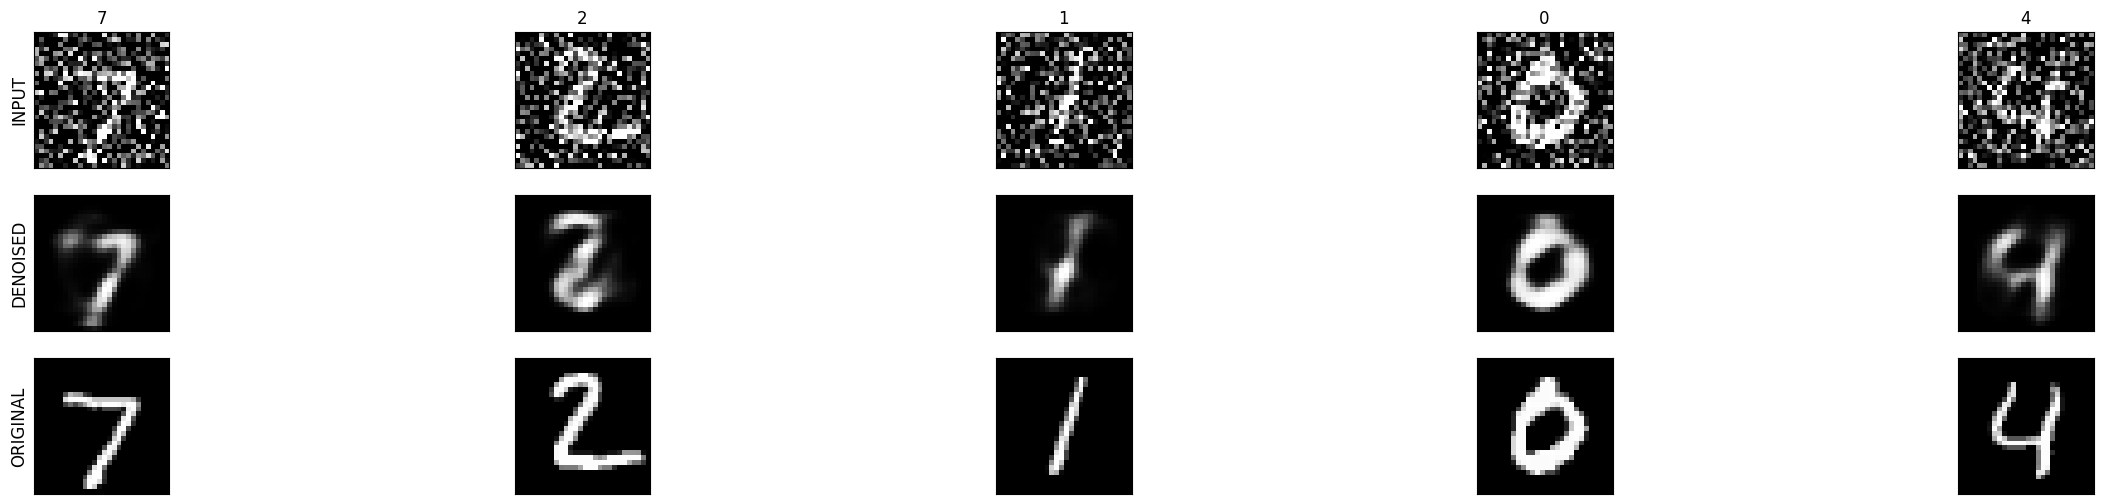

In [22]:
check_results(noisy, denoised, X_test, y_test)